In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import mygene
import os
pd.set_option('display.max_columns', None)

# Set the working directory
working_dir = "/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_Snords"
os.chdir(working_dir)
print(f"Current working directory: {os.getcwd()}")

from functions import check_dexseq_results


# Examind the data

In [57]:
# Example usage
results_file = "output_v38/dexseq_results_PW1_vs_combined_controls.csv"
df = pd.read_csv(results_file)

In [58]:
df.head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.15:E001,ENSG00000000003.15,E001,9.064419,0.016163,3928.904378,0.000000e+00,0.000000e+00,5.931265,5.009454,-0.513830,chrX,100627108,100627108,1,-,10,12,6,2,10,8,12,10,14
1,ENSG00000000003.15:E002,ENSG00000000003.15,E002,1364.225638,0.007380,465.843450,6.972364e-102,8.791361e-102,31.857029,31.513293,-0.075000,chrX,100627109,100629986,2878,-,1106,1345,750,970,1266,1057,1521,2781,2375
2,ENSG00000000003.15:E003,ENSG00000000003.15,E003,443.805530,0.009201,1962.650578,0.000000e+00,0.000000e+00,24.503872,24.252599,-0.056804,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.15:E004,ENSG00000000003.15,E004,1.978581,0.020921,3476.876104,0.000000e+00,0.000000e+00,2.634388,2.801898,0.180282,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.15:E005,ENSG00000000003.15,E005,330.134019,0.007735,2830.512068,0.000000e+00,0.000000e+00,22.609421,22.418042,-0.044010,chrX,100632485,100632540,56,-,269,321,184,215,299,267,354,675,613


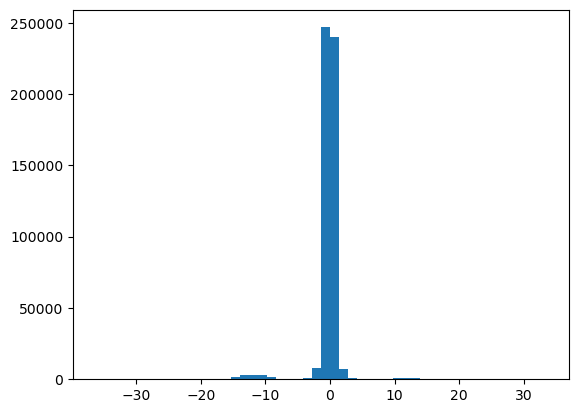

In [59]:
hist = plt.hist(df['log2fold_treated_control'], bins=50)


In [60]:
summary_stats = check_dexseq_results(results_file)

Loading results file...

=== Basic Statistics ===
Total number of tests: 521736
Number of NA p-values: 0
Number of NA adjusted p-values: 0
Number of significant results (padj < 0.05): 519126
Number of significant results (padj < 0.1): 519584

=== Fold Change Statistics ===
count    521191.000000
mean         -0.226736
std           2.378084
min         -36.328054
25%          -0.201142
50%          -0.008559
75%           0.174384
max          33.535337
Name: log2fold_treated_control, dtype: float64

=== Potential Issues ===
Number of potentially problematic results: 50524

Sample of problematic results:
                groupID featureID  log2fold_treated_control  dispersion  \
16   ENSG00000000003.15      E017                -10.346867    0.044316   
61   ENSG00000000419.14      E037                 10.565897    0.051396   
84   ENSG00000000460.17      E002                -10.683699    0.055891   
87   ENSG00000000460.17      E006                 -9.683355    0.093720   
129  ENSG0000

/home/kubacki.michal/.conda/envs/jupyter_nb/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)



=== Checking Problematic Genes ===

Results for ENSG00000285404.1:
       featureID  log2fold_treated_control         pvalue           padj  \
161835      E001                       NaN   0.000000e+00   0.000000e+00   
161836      E002                       NaN   0.000000e+00   0.000000e+00   
161837      E003                       NaN   0.000000e+00   0.000000e+00   
161838      E004                       NaN   0.000000e+00   0.000000e+00   
161839      E005                       NaN  5.156697e-245  8.029014e-245   

        dispersion  
161835    0.053427  
161836    0.059300  
161837    0.059300  
161838    0.066385  
161839    0.115896  

Results for ENSG00000128245.15:
       featureID  log2fold_treated_control         pvalue           padj  \
161835      E001                       NaN   0.000000e+00   0.000000e+00   
161836      E002                       NaN   0.000000e+00   0.000000e+00   
161837      E003                       NaN   0.000000e+00   0.000000e+00   
161838      

In [61]:
# Print summary
print("\n=== Analysis Summary ===")
for key, value in summary_stats.items():
    print(f"{key}: {value}")


=== Analysis Summary ===
total_tests: 521736
significant_005: 519126
significant_01: 519584
na_pvalues: 0
problematic_count: 50524
median_dispersion: 0.019585848482279303
median_fold_change: -0.0085588454799916


# Select significant results

In [62]:
df_sig = df[df['padj'] < 0.05]

In [63]:
print(df.shape)
print(df_sig.shape)

(521736, 25)
(519126, 25)


In [64]:
df = df_sig

# Remove overlapping genes

In [65]:
df[df['groupID'].str.contains('\+')].head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
575,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,E001,0.536916,0.041447,1887.091874,0.0,0.0,1.597294,0.939031,-1.537197,chr7,1815793,1815793,1,-,0,1,0,1,1,1,0,1,0
576,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,E002,0.536916,0.041447,1887.091874,0.0,0.0,1.597294,0.939031,-1.537197,chr7,1815794,1815794,1,-,0,1,0,1,1,1,0,1,0
577,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,E003,14.452441,0.018770,2893.809896,0.0,0.0,7.079699,6.199785,-0.413438,chr7,1815795,1815803,9,-,14,19,7,10,22,14,18,13,15
578,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,E004,34.308638,0.011535,3707.330284,0.0,0.0,10.165546,9.595819,-0.195260,chr7,1815804,1815815,12,-,30,35,30,26,44,29,30,47,46
579,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,ENSG00000002822.16+ENSG00000122687.19+ENSG0000...,E005,131.484201,0.011952,2340.306703,0.0,0.0,16.693577,16.753098,0.015076,chr7,1815816,1816081,266,-,112,124,106,121,157,88,144,190,180


In [66]:
df = df[~df['groupID'].str.contains('\+')]

In [67]:
df.head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
0,ENSG00000000003.15:E001,ENSG00000000003.15,E001,9.064419,0.016163,3928.904378,0.000000e+00,0.000000e+00,5.931265,5.009454,-0.513830,chrX,100627108,100627108,1,-,10,12,6,2,10,8,12,10,14
1,ENSG00000000003.15:E002,ENSG00000000003.15,E002,1364.225638,0.007380,465.843450,6.972364e-102,8.791361e-102,31.857029,31.513293,-0.075000,chrX,100627109,100629986,2878,-,1106,1345,750,970,1266,1057,1521,2781,2375
2,ENSG00000000003.15:E003,ENSG00000000003.15,E003,443.805530,0.009201,1962.650578,0.000000e+00,0.000000e+00,24.503872,24.252599,-0.056804,chrX,100630759,100630866,108,-,375,434,254,277,397,359,471,926,802
3,ENSG00000000003.15:E004,ENSG00000000003.15,E004,1.978581,0.020921,3476.876104,0.000000e+00,0.000000e+00,2.634388,2.801898,0.180282,chrX,100632063,100632068,6,-,1,2,1,1,4,0,2,5,4
4,ENSG00000000003.15:E005,ENSG00000000003.15,E005,330.134019,0.007735,2830.512068,0.000000e+00,0.000000e+00,22.609421,22.418042,-0.044010,chrX,100632485,100632540,56,-,269,321,184,215,299,267,354,675,613


# Check problematic genes

In [68]:
# List of problematic genes from the error message
# problematic_genes = ['ENSG00000285404.1', 'ENSG00000100150.19', 
#                     'ENSG00000128245.15', 'ENSG00000252909.1']

# Create masks for each condition
extreme_fc_mask = (df['log2fold_treated_control'].abs() > 5)
high_disp_mask = (df['dispersion'] > 10)
missing_vals_mask = (
    df['log2fold_treated_control'].isna() |
    df['pvalue'].isna() |
    df['padj'].isna()
)
extreme_stat_mask = (df['stat'].abs() > 10000)
# problematic_genes_mask = df['groupID'].str.contains('|'.join(problematic_genes), regex=True)

# Print counts for each condition
print(f"Records with extreme fold changes (>5): {extreme_fc_mask.sum()}")
print(f"Records with high dispersion (>10): {high_disp_mask.sum()}")
print(f"Records with missing values: {missing_vals_mask.sum()}")
print(f"Records with extreme test statistics (>10000): {extreme_stat_mask.sum()}")
# print(f"Records from problematic genes: {problematic_genes_mask.sum()}")

Records with extreme fold changes (>5): 13691
Records with high dispersion (>10): 0
Records with missing values: 62
Records with extreme test statistics (>10000): 22703


In [69]:
df.columns

Index(['Unnamed: 0', 'groupID', 'featureID', 'exonBaseMean', 'dispersion',
       'stat', 'pvalue', 'padj', 'control', 'treated',
       'log2fold_treated_control', 'genomicData.seqnames', 'genomicData.start',
       'genomicData.end', 'genomicData.width', 'genomicData.strand',
       'countData.EDO_1', 'countData.EDO_2', 'countData.EDO_3',
       'countData.ND1_1', 'countData.ND1_2', 'countData.ND1_3',
       'countData.PW1_1', 'countData.PW1_2', 'countData.PW1_3'],
      dtype='object')

# Examine extreme test statistics

In [70]:
# Print genes with extreme test statistics
# print(list(df[extreme_stat_mask]['groupID'].unique()))
df[extreme_stat_mask].head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
863,ENSG00000003393.16:E001,ENSG00000003393.16,E001,11.697157,0.002541,20525.076598,0.0,0.0,6.242655,5.713384,-0.272195,chr2,201700267,201700513,247,-,20,15,10,15,4,5,11,13,13
864,ENSG00000003393.16:E002,ENSG00000003393.16,E002,18.889202,0.001698,26604.916049,0.0,0.0,7.828913,7.257410,-0.241117,chr2,201700514,201700559,46,-,26,18,12,21,17,19,11,27,24
865,ENSG00000003393.16:E003,ENSG00000003393.16,E003,18.472341,0.001728,26315.567648,0.0,0.0,7.766018,7.149807,-0.262434,chr2,201700560,201700560,1,-,26,17,11,21,17,19,11,25,24
866,ENSG00000003393.16:E004,ENSG00000003393.16,E004,18.472341,0.001728,26315.567648,0.0,0.0,7.766018,7.149807,-0.262434,chr2,201700561,201700561,1,-,26,17,11,21,17,19,11,25,24
867,ENSG00000003393.16:E005,ENSG00000003393.16,E005,20.188860,0.001718,26306.611970,0.0,0.0,8.012901,7.570321,-0.181837,chr2,201700562,201700564,3,-,26,18,11,24,18,22,14,25,29


In [71]:
df.sort_values('stat', ascending=False)[:10]

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
261625,ENSG00000155506.18:E016,ENSG00000155506.18,E016,659.429326,0.000447,63305.493904,0.0,0.0,26.511968,26.752889,0.053641,chr5,154793650,154793723,74,+,588,657,476,635,652,585,646,914,981
261654,ENSG00000155506.18:E045,ENSG00000155506.18,E045,529.238438,0.000508,60978.314891,0.0,0.0,25.168404,25.186281,0.004017,chr5,154811247,154811351,105,+,499,501,402,504,558,453,501,714,779
261626,ENSG00000155506.18:E017,ENSG00000155506.18,E017,517.395431,0.000525,59837.306577,0.0,0.0,24.868370,25.315753,0.100595,chr5,154793800,154793824,25,+,446,515,371,484,511,457,535,717,780
261647,ENSG00000155506.18:E038,ENSG00000155506.18,E038,578.648105,0.000509,59645.375347,0.0,0.0,25.853190,25.549756,-0.067944,chr5,154804221,154804307,87,+,547,563,438,580,617,500,532,775,803
261633,ENSG00000155506.18:E024,ENSG00000155506.18,E024,667.575011,0.000489,59183.214958,0.0,0.0,26.962954,26.084921,-0.195619,chr5,154795175,154795186,12,+,686,701,507,642,701,615,570,813,910
261657,ENSG00000155506.18:E048,ENSG00000155506.18,E048,573.487530,0.000539,57313.404813,0.0,0.0,25.538715,25.976068,0.097895,chr5,154811513,154811640,128,+,531,550,441,546,560,461,560,823,872
125653,ENSG00000115306.16:E045,ENSG00000115306.16,E045,451.054240,0.000804,56644.285549,0.0,0.0,24.129997,23.609628,-0.118134,chr2,54660291,54662308,2018,+,444,499,343,481,502,421,370,537,529
261655,ENSG00000155506.18:E046,ENSG00000155506.18,E046,419.231556,0.000644,53973.693911,0.0,0.0,23.520612,23.994457,0.107677,chr5,154811352,154811356,5,+,379,373,323,393,429,355,405,604,647
261642,ENSG00000155506.18:E033,ENSG00000155506.18,E033,594.149906,0.000587,53355.918172,0.0,0.0,25.830784,26.030699,0.044698,chr5,154802350,154802399,50,+,534,563,448,549,588,549,611,791,866
366483,ENSG00000184009.13:E026,ENSG00000184009.13,E026,551.993080,0.001447,52527.104771,0.0,0.0,25.239015,25.676504,0.098121,chr17,81512143,81512150,8,-,500,553,429,490,571,487,531,798,762


In [72]:
n_sel = 100 
stat_sel = list(df.sort_values('stat', ascending=False)[:n_sel]['groupID'][~df.sort_values('stat', ascending=False)[:n_sel]['groupID'].str.contains('\+')].unique())
print(stat_sel)


['ENSG00000155506.18', 'ENSG00000115306.16', 'ENSG00000184009.13', 'ENSG00000038382.20', 'ENSG00000125462.19', 'ENSG00000117139.18', 'ENSG00000132466.19', 'ENSG00000172270.22', 'ENSG00000115464.15', 'ENSG00000125107.19', 'ENSG00000204463.13', 'ENSG00000151914.21', 'ENSG00000197535.15', 'ENSG00000163618.18', 'ENSG00000078369.18']


In [73]:
# Initialize mygene client
mg = mygene.MyGeneInfo()

# Remove version numbers from ENSEMBL IDs
stat_sel_no_version = [id.split('.')[0] for id in stat_sel]

# Query the gene symbols
# results = mg.querymany(stat_sel_no_version, scopes='ensembl.gene', fields='symbol', species='human')
results = mg.querymany(stat_sel_no_version, 
                      scopes='ensembl.gene', 
                      fields='symbol', 
                      species='human',
                      assembly='GRCh38')

# Create a dictionary mapping ENSEMBL IDs to symbols
gene_map = {res['query']: res.get('symbol', 'Not found') for res in results}

gene_symbols = [gene_map[ensembl_id.split('.')[0]] for ensembl_id in stat_sel]

ensembl_to_symbol = dict(zip(stat_sel, gene_symbols))

# Print results
for ensembl, symbol in ensembl_to_symbol.items():
    print(f"{ensembl}: {symbol}")

ENSG00000155506.18: LARP1
ENSG00000115306.16: SPTBN1
ENSG00000184009.13: ACTG1
ENSG00000038382.20: TRIO
ENSG00000125462.19: MIR9-1HG
ENSG00000117139.18: KDM5B
ENSG00000132466.19: ANKRD17
ENSG00000172270.22: BSG
ENSG00000115464.15: USP34
ENSG00000125107.19: CNOT1
ENSG00000204463.13: BAG6
ENSG00000151914.21: DST
ENSG00000197535.15: MYO5A
ENSG00000163618.18: CADPS
ENSG00000078369.18: GNB1


In [74]:
# Examine records with extreme test statistics
extreme_stat_records = df[extreme_stat_mask][['groupID', 'featureID', 'stat', 'pvalue', 'padj', 'log2fold_treated_control', 'dispersion']]
print("\nSample of records with extreme test statistics:")
extreme_stat_records.head()



Sample of records with extreme test statistics:


,groupID,featureID,stat,pvalue,padj,log2fold_treated_control,dispersion
863,ENSG00000003393.16,E001,20525.076598,0.0,0.0,-0.272195,0.002541
864,ENSG00000003393.16,E002,26604.916049,0.0,0.0,-0.241117,0.001698
865,ENSG00000003393.16,E003,26315.567648,0.0,0.0,-0.262434,0.001728
866,ENSG00000003393.16,E004,26315.567648,0.0,0.0,-0.262434,0.001728
867,ENSG00000003393.16,E005,26306.611970,0.0,0.0,-0.181837,0.001718


# Examine extreme fold changes

In [75]:
# Print genes with extreme fold changes
# print(list(df[extreme_fc_mask]['groupID'].unique()))
df[extreme_fc_mask].head()

,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
16,ENSG00000000003.15:E017,ENSG00000000003.15,E017,0.424628,0.044316,1985.946299,0.000000e+00,0.000000e+00,1.531112,0.042519,-10.346867,chrX,100639945,100639991,47,-,1,0,2,0,0,0,0,0,0
61,ENSG00000000419.14:E037,ENSG00000000419.14,E037,0.282341,0.051396,1621.257073,0.000000e+00,0.000000e+00,0.042780,1.661381,10.565897,chr20,50958741,50959140,400,-,0,0,0,0,0,0,1,0,2
84,ENSG00000000460.17:E002,ENSG00000000460.17,E002,0.222273,0.055891,1249.492076,4.745076e-272,7.671664e-272,1.096678,0.027071,-10.683699,chr1,169683469,169683625,157,+,0,0,0,1,1,0,0,0,0
87,ENSG00000000460.17:E006,ENSG00000000460.17,E006,0.108077,0.093720,843.762088,6.017145e-184,8.593950e-184,0.775805,0.027071,-9.683355,chr1,169794730,169794905,176,+,0,1,0,0,0,0,0,0,0
129,ENSG00000000971.16:E008,ENSG00000000971.16,E008,0.394678,0.636638,108.934934,2.213500e-24,2.358157e-24,0.032508,1.929387,11.792232,chr1,196676988,196677475,488,+,0,0,0,0,0,0,0,3,2


In [76]:
df.sort_values('log2fold_treated_control', key=abs, ascending=False)[:10]


,Unnamed: 0,groupID,featureID,exonBaseMean,dispersion,stat,pvalue,padj,control,treated,log2fold_treated_control,genomicData.seqnames,genomicData.start,genomicData.end,genomicData.width,genomicData.strand,countData.EDO_1,countData.EDO_2,countData.EDO_3,countData.ND1_1,countData.ND1_2,countData.ND1_3,countData.PW1_1,countData.PW1_2,countData.PW1_3
149876,ENSG00000123572.17:E032,ENSG00000123572.17,E032,5.179229,2.372678,19.233449,6.660544e-05,6.739156e-05,4.440830,0.000066,-32.116542,chrX,105948438,105948759,322,+,0,0,0,12,15,17,0,0,0
390083,ENSG00000196834.13:E021,ENSG00000196834.13,E021,0.362087,0.082622,465.796207,7.139023e-102,9.001216e-102,1.652174,0.000026,-31.940155,chr2,130503324,130503445,122,-,0,0,0,2,0,1,0,0,0
390079,ENSG00000196834.13:E017,ENSG00000196834.13,E017,0.108077,0.151142,324.042277,4.316319e-71,5.144747e-71,0.954015,0.000026,-30.339995,chr2,130490670,130490740,71,-,0,1,0,0,0,0,0,0,0
482790,ENSG00000261824.7:E119,ENSG00000261824.7,E119,0.363474,0.792843,171.080335,7.085611e-38,7.850922e-38,0.000059,1.639852,29.537861,chr19,27793892,27793893,2,-,0,0,0,0,0,0,1,0,3
390087,ENSG00000196834.13:E026,ENSG00000196834.13,E026,0.081133,0.176365,291.540797,4.928564e-64,5.794228e-64,0.000038,0.786067,28.687156,chr2,130509668,130509707,40,-,0,0,0,0,0,0,0,0,1
149847,ENSG00000123572.17:E003,ENSG00000123572.17,E003,0.391014,1.006492,65.472464,6.065059e-15,6.286849e-15,1.204656,0.000066,-28.304566,chrX,105822581,105822902,322,+,0,1,1,0,0,1,0,0,0
149845,ENSG00000123572.17:E001,ENSG00000123572.17,E001,0.282937,1.185551,59.188503,1.404041e-13,1.449961e-13,0.994277,0.000066,-27.757130,chrX,105822539,105822552,14,+,0,0,1,0,0,1,0,0,0
149846,ENSG00000123572.17:E002,ENSG00000123572.17,E002,0.282937,1.185551,59.188503,1.404041e-13,1.449961e-13,0.994277,0.000066,-27.749547,chrX,105822553,105822580,28,+,0,0,1,0,0,1,0,0,0
149874,ENSG00000123572.17:E030,ENSG00000123572.17,E030,0.153842,1.395257,53.800921,2.076244e-12,2.137362e-12,0.703072,0.000066,-26.748300,chrX,105945872,105946015,144,+,0,0,1,0,0,0,0,0,0
494438,ENSG00000272168.8:E202,ENSG00000272168.8,E202,1.061682,0.117592,931.437795,5.506209e-203,8.080137e-203,2.097197,0.000202,-26.702272,chr6,22610564,22610640,77,+,2,1,3,0,0,2,0,0,0


In [77]:
n_sel = 100 
fc_sel = list(df.sort_values('log2fold_treated_control', key=abs, ascending=False)[:n_sel]['groupID'][~df.sort_values('log2fold_treated_control', key=abs, ascending=False)[:n_sel]['groupID'].str.contains('\+')].unique())
print(fc_sel)



['ENSG00000123572.17', 'ENSG00000196834.13', 'ENSG00000261824.7', 'ENSG00000272168.8', 'ENSG00000196090.12', 'ENSG00000178104.19', 'ENSG00000185666.15', 'ENSG00000168781.22', 'ENSG00000273079.7', 'ENSG00000162105.20', 'ENSG00000136205.17', 'ENSG00000251209.9', 'ENSG00000008513.16', 'ENSG00000160200.18', 'ENSG00000205592.15', 'ENSG00000146592.17', 'ENSG00000260691.7', 'ENSG00000008086.13', 'ENSG00000168214.21', 'ENSG00000274276.4', 'ENSG00000185304.15', 'ENSG00000177359.20', 'ENSG00000188611.17', 'ENSG00000237945.7', 'ENSG00000215580.11', 'ENSG00000109099.16', 'ENSG00000228696.10', 'ENSG00000164756.13', 'ENSG00000180398.13', 'ENSG00000142178.9']


In [78]:
# Initialize mygene client
mg = mygene.MyGeneInfo()

# Remove version numbers from ENSEMBL IDs
fc_sel_no_version = [id.split('.')[0] for id in fc_sel]

# Query the gene symbols
# results = mg.querymany(fc_sel_no_version, scopes='ensembl.gene', fields='symbol', species='human')
results = mg.querymany(fc_sel_no_version, 
                      scopes='ensembl.gene', 
                      fields='symbol', 
                      species='human',
                      assembly='GRCh38')

# Create a dictionary mapping ENSEMBL IDs to symbols
gene_map = {res['query']: res.get('symbol', 'Not found') for res in results}

gene_symbols = [gene_map[ensembl_id.split('.')[0]] for ensembl_id in fc_sel]

ensembl_to_symbol = dict(zip(fc_sel, gene_symbols))

# Print results
for ensembl, symbol in ensembl_to_symbol.items():
    print(f"{ensembl}: {symbol}")

ENSG00000123572.17: NRK
ENSG00000196834.13: POTEI
ENSG00000261824.7: LINC00662
ENSG00000272168.8: CASC15
ENSG00000196090.12: PTPRT
ENSG00000178104.19: PDE4DIP
ENSG00000185666.15: SYN3
ENSG00000168781.22: PPIP5K1
ENSG00000273079.7: GRIN2B
ENSG00000162105.20: SHANK2
ENSG00000136205.17: TNS3
ENSG00000251209.9: LINC00923
ENSG00000008513.16: ST3GAL1
ENSG00000160200.18: CBS
ENSG00000205592.15: MUC19
ENSG00000146592.17: CREB5
ENSG00000260691.7: ANKRD20A1
ENSG00000008086.13: CDKL5
ENSG00000168214.21: RBPJ
ENSG00000274276.4: LOC102724560
ENSG00000185304.15: RGPD2
ENSG00000177359.20: OVOS2
ENSG00000188611.17: ASAH2
ENSG00000237945.7: LINC00649
ENSG00000215580.11: BCORP1
ENSG00000109099.16: PMP22
ENSG00000228696.10: ARL17B
ENSG00000164756.13: SLC30A8
ENSG00000180398.13: MCFD2
ENSG00000142178.9: SIK1


# Save filtered results

In [79]:
clean_df = df[
    (df['log2fold_treated_control'].notna()) &
    (df['pvalue'].notna()) &
    (df['padj'].notna())
]

# Print summary of filtering
print(f"Original number of records: {len(df)}")
print(f"Number of records after cleaning: {len(clean_df)}")
print(f"Number of records removed: {len(df) - len(clean_df)}")

# Save cleaned results to new CSV file
output_file = "output/dexseq_results_PW1_vs_combined_controls_cleaned_permisive.csv"
clean_df.to_csv(output_file, index=False)
print(f"\nCleaned results saved to: {output_file}")

# Print summary statistics of cleaned data
print(clean_df['log2fold_treated_control'].describe())

Original number of records: 415118
Number of records after cleaning: 415056
Number of records removed: 62

Cleaned results saved to: output/dexseq_results_PW1_vs_combined_controls_cleaned_permisive.csv
count    415056.000000
mean         -0.207645
std           2.274334
min         -32.116542
25%          -0.190337
50%          -0.007210
75%           0.169498
max          29.537861
Name: log2fold_treated_control, dtype: float64


In [80]:
extreme_stat_records['groupID'].value_counts()

groupID
ENSG00000109339.24    223
ENSG00000197102.14    175
ENSG00000151914.21    172
ENSG00000127603.31    158
ENSG00000115355.17    149
                     ... 
ENSG00000168887.11      1
ENSG00000167965.18      1
ENSG00000166889.14      1
ENSG00000086475.15      1
ENSG00000144218.21      1
Name: count, Length: 967, dtype: int64

In [81]:
clean_df = df[
    # Remove extreme fold changes (keeping values between -5 and 5)
    (df['log2fold_treated_control'].abs() <= 5) &
    # Remove high dispersion
    (df['dispersion'] <= 10) &
    # Remove missing values
    (df['log2fold_treated_control'].notna()) &
    (df['pvalue'].notna()) &
    (df['padj'].notna()) &
    # Remove extreme test statistics
    (df['stat'].abs() <= 10000)
]

# Print summary of filtering
print(f"Original number of records: {len(df)}")
print(f"Number of records after cleaning: {len(clean_df)}")
print(f"Number of records removed: {len(df) - len(clean_df)}")

# Save cleaned results to new CSV file
output_file = "output/dexseq_results_PW1_vs_combined_controls_cleaned.csv"
clean_df.to_csv(output_file, index=False)
print(f"\nCleaned results saved to: {output_file}")

# Print summary statistics of cleaned data
print(clean_df['log2fold_treated_control'].describe())

Original number of records: 415118
Number of records after cleaning: 378662
Number of records removed: 36456

Cleaned results saved to: output/dexseq_results_PW1_vs_combined_controls_cleaned.csv
count    378662.000000
mean         -0.001703
std           0.525406
min          -4.981342
25%          -0.176239
50%          -0.002437
75%           0.175018
max           4.955280
Name: log2fold_treated_control, dtype: float64
